<a href="https://colab.research.google.com/github/praveenjune17/Neural-Machine-Translation-English-Tamil-model/blob/master/eng_tam_Neural_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural Machine Translation with Attention

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import unicodedata
import re
import numpy as np
import os
import io
import time
import random

!pip install tensorflow-gpu==2.0.0-beta0

In [0]:
import shutil
shutil.rmtree('../content/training_checkpoints/')

In [0]:
#!git clone https://github.com/joshua-decoder/indian-parallel-corpora

In [0]:
#!unrar x training_checkpoints.rar

## Download and prepare the dataset

#### Inspired by 
https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb

The dataset is downloaded

a) github.com/achchuthany/En-Ta-Parallel-Corpus

b) github.com/joshua-decoder/indian-parallel-corpora



### Goal
Convert Tamil sentences to english sentences using a Basic Seq2Seq with attention

In [0]:
#!cat '../content/amazon_terk.new' '../content/train.en-ta-filtered.write_newfilt' > '../content/allset.new'
#21 is the limit

In [0]:
#!7za e En-tam_corpus_sorted_duped.7z

In [0]:
# Download the file
#path_to_en_file = '../content/train.en-ta.en'
#path_to_new_file = '../content/train.en-ta-filtered.write_few'
#path_to_ta_file = '../content/train.en-ta-ta.ta'
#path_to_file = '../content/train.en-ta-filtered.write_newfilt'   #achuchuthany dataset filt
path_to_file = '../content/En-tam_corpus_sorted_duped.new'
#path_to_en_file ='../content/indian-parallel-corpora/ta-en/training.ta-en.en'
#path_to_ta_file ='../content/indian-parallel-corpora/ta-en/training.ta-en.ta'
#path_to_file = '../content/amazon_terk.new'


In [3]:

with open(path_to_file ,'r',encoding='utf-8') as file_r:
  count=0
  for line in file_r:


    count+=1
  print(count)

203322


In [0]:
# # with open(path_to_file,'r') as file_write:
# #   for line in file_write:
# #     print(line)
# #     break
# import random
# def random_line(afile):
#     line = next(afile)
#     for num, aline in enumerate(afile, 2):
#       if random.randrange(num): continue
#       line = aline
#     return line
    
# with open(path_to_file,'r') as file_write:
#   print (random_line(file_write))


In [0]:
# statinfo = os.stat(path_to_file)
# print ('file created is size of {}'.format(str(statinfo.st_size/1024**2)+' MB'))

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w,language='tamil'):
    #w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    if language=='english':
      w = unicode_to_ascii(w.lower().strip())
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    else:
     
      w = re.sub(r"([?.!,¿])", r" \1 ", w.strip())
      w = re.sub(r'[" "]+', " ", w)
      w = re.sub('[a-zA-Z?.!]+', " ", w) #replace english alphabets in tamil sentence
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"alternative current"
ta_sentence = u"இராணுவம் சாம்பூர் பிரதேசத்தை குண்டுகளால் சேதப்படுத்துவதன் மூலம் பதிலடி கொடுத்தது."

print(preprocess_sentence(ta_sentence))
print(preprocess_sentence(en_sentence,'english'))

<start> இராணுவம் சாம்பூர் பிரதேசத்தை குண்டுகளால் சேதப்படுத்துவதன் மூலம் பதிலடி கொடுத்தது <end>
<start> alternative current <end>


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, TAMIL]
def create_dataset(path,num_examples):
  ex1=[]
  ex2=[]
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)
    #word_pairs = [[preprocess_sentence(w,language) for w in l.split('\t')]  for l in lines[:num_examples]]
    #word_pairs = [[preprocess_sentence(w,language) for w in l.split('\t')]  for l in lines[:num_examples]]
  for l in lines[:num_examples]:
    #print(l)
    
    eng,ta= (l.split('\t'))
    #if len(eng.split()) > threshold:
    #  continue
    #if len(ta.split()) > threshold:
    #  continue
    ex1.append(preprocess_sentence(eng,language='english'))
    ex2.append(preprocess_sentence(ta,language='tamil'))
    

  return zip(*list(zip(ex1,ex2)))

In [7]:
en,ta  = create_dataset(path_to_file, 10)

print(en[-1])
print(ta[-1])

<start> selvi <end>
<start> செல்வி <end>


#### Create a traning set which contain pairs of english , tamil sentences.Filtering out sentences of length greater than the threshold since long sentences consumes much of GPU memory

In [0]:
def remove_extra(input_tensor,target_tensor,threshold):
  


  max_values = []
  max_values_targ=[]
  
  for i,j in zip(input_tensor,target_tensor):
    if len(i) > threshold:
      max_values.append(i)
    if len(j) > threshold:
      max_values_targ.append(j)
    
  
  for val_ip in max_values:
    rem_index_ip = input_tensor.index(val_ip)
    _=input_tensor.pop(rem_index_ip)
    _=target_tensor.pop(rem_index_ip)
    if val_ip in max_values_targ:
      rem_index_tar = (target_tensor.index(val_ip))
      target_tensor.pop(rem_index_tar)
  
  for val_tar in max_values_targ:
    rem_index_tar = target_tensor.index(val_tar)
    _=target_tensor.pop(rem_index_tar)
    _=input_tensor.pop(rem_index_tar)
    if val_tar in max_values:
      rem_index_ip = (input_tensor.index(val_tar))
      input_tensor.pop(rem_index_ip)
    
  return(input_tensor,target_tensor)

In [0]:


def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(inp_lang,targ_lang):
  inp_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  inp_lang_tokenizer.fit_on_texts(inp_lang)

  ip_tensor = inp_lang_tokenizer.texts_to_sequences(inp_lang)          #convert the words to numbers of varying lengths
  
  targ_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  targ_lang_tokenizer.fit_on_texts(targ_lang)

  tar_tensor = targ_lang_tokenizer.texts_to_sequences(targ_lang)          #convert the words to numbers of varying lengths
  #ip_tensor,tar_tensor = remove_long_sentence(ip_tensor,tar_tensor,threshold)
  #ip_tensor = tf.keras.preprocessing.sequence.pad_sequences(ip_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                         #padding='post')
  #tar_tensor = tf.keras.preprocessing.sequence.pad_sequences(tar_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                         #padding='post')
  

  return ip_tensor,inp_lang_tokenizer,tar_tensor,targ_lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang,targ_lang  = create_dataset(path, num_examples)
    
    
    
    
    input_tensor, inp_lang_tokenizer, target_tensor, targ_lang_tokenizer = tokenize(inp_lang,targ_lang)
    unk_id = list(inp_lang_tokenizer.word_index.values())[-1] + 1
    inp_lang_tokenizer.word_index['<UNK>'] = unk_id
    inp_lang_tokenizer.index_word[unk_id]  = '<UNK>'
    #target_tensor, targ_lang_tokenizer = tokenize(targ_lang,threshold=threshold)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, unk_id

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [35]:
# Try experimenting with the size of that dataset
num_examples = 50000
#input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
input_tensor, target_tensor, inp_lang, targ_lang,unk_id = load_dataset(path_to_file, num_examples)
#input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,#set the length of the sequences to be same by padding zeros in the end
#                                                         padding='post')
#target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,#set the length of the sequences to be same by padding zeros in the end
#                                                         padding='post')

# Calculate max_length of the target tensors
prev_ip = len(input_tensor)
prev_tar = len(target_tensor)
input_tensor,target_tensor = remove_extra(input_tensor,target_tensor,threshold=17)
after_ip = len(input_tensor)
after_tar = len(target_tensor)

print('{} and {} sentences removed from ip and target tensor after filtering by threshold'.format((prev_ip-after_ip),(prev_tar-after_tar)))
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                        padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,#set the length of the sequences to be same by padding zeros in the end
                                                        padding='post')
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

#temp = max_length(input_tensor)
#print('*******')
print(max_length_targ)
print(max_length_inp)


39 and 39 sentences removed from ip and target tensor after filtering by threshold
17
17


In [36]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.01)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(49461, 49461, 500, 500)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [38]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> the
1512 ----> lucky
326 ----> man
118 ----> who
12 ----> s
8 ----> to
3525 ----> wed
3453 ----> meena
5 ----> is
44 ----> an
6501 ----> industrialist
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
43572 ----> மீனாவின்
43573 ----> கழுத்தில்
43574 ----> தாலிகட்டப்போகும்
33 ----> அந்த
43575 ----> மலேசியாக்காரர்
13353 ----> ஸாரி
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [40]:
print(vocab_inp_size,vocab_tar_size)

24445 53416


In [41]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 17]), TensorShape([128, 17]))

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [43]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 17, 512)
Encoder Hidden state shape: (batch size, units) (128, 512)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [45]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 512)
Attention weights shape: (batch_size, sequence_length, 1) (128, 17, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [47]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 53416)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
      
  #print('loop ended')
  batch_loss = (loss / int(targ.shape[1]))
  #print('batch caclulation ended')
  variables = encoder.trainable_variables + decoder.trainable_variables
  #print('variables summed')
  gradients = tape.gradient(loss, variables)
  #print('gradients calculated summed')
  optimizer.apply_gradients(zip(gradients, variables))
  #print('optimizer applies')
  return batch_loss

In [51]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
  
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.5169
Epoch 1 Batch 100 Loss 2.5404
Epoch 1 Batch 200 Loss 2.3940
Epoch 1 Batch 300 Loss 2.7598
Epoch 1 Loss 2.7151
Time taken for 1 epoch 323.64270520210266 sec

Epoch 2 Batch 0 Loss 2.6349
Epoch 2 Batch 100 Loss 2.3119
Epoch 2 Batch 200 Loss 2.2196
Epoch 2 Batch 300 Loss 2.5850
Epoch 2 Loss 2.4818
Time taken for 1 epoch 277.32703709602356 sec

Epoch 3 Batch 0 Loss 2.5020
Epoch 3 Batch 100 Loss 2.2109
Epoch 3 Batch 200 Loss 2.0870
Epoch 3 Batch 300 Loss 2.4016
Epoch 3 Loss 2.3441
Time taken for 1 epoch 274.45193243026733 sec

Epoch 4 Batch 0 Loss 2.3357
Epoch 4 Batch 100 Loss 2.0435
Epoch 4 Batch 200 Loss 1.8785
Epoch 4 Batch 300 Loss 2.1554
Epoch 4 Loss 2.1299
Time taken for 1 epoch 275.51321959495544 sec

Epoch 5 Batch 0 Loss 2.1177
Epoch 5 Batch 100 Loss 1.8341
Epoch 5 Batch 200 Loss 1.7069
Epoch 5 Batch 300 Loss 1.9058
Epoch 5 Loss 1.9009
Time taken for 1 epoch 272.8918364048004 sec

Epoch 6 Batch 0 Loss 1.9142
Epoch 6 Batch 100 Loss 1.6396
Epoch 6 Batch 200 

**GPU memory full but still running**

a ) Tamil vocab size with 142182 tokens in the final softmax layer consumes fully GPU memory
b)  English tokens 42697
c)  Max_token length set to 17

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [0]:
def evaluate(sentence,unk_id,sample_size):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #print(sentence)
    sentence = preprocess_sentence(sentence,language='english')

    #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = [inp_lang.word_index.get(i,unk_id) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        #predicted_id = tf.argmax(predictions[0]).numpy()
        distribution = tf.argsort(predictions[0],direction='DESCENDING').numpy()[:sample_size]
        random.seed(1)
        predicted_id = random.choice(distribution)

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [84]:
targ_lang.word_index['நல்வரவு']

22504

In [82]:
inp_lang.index_word[unk_id]

'<UNK>'

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence,unk_id,sample_size=5)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [0]:
# restoring the latest checkpoint in checkpoint_dir

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).assert_consumed()

In [0]:

def calc_BLEU():
  start=time.time()
  score = 0
  for targ,sour_input in zip(targ_lang.sequences_to_texts(target_tensor_val),inp_lang.sequences_to_texts(input_tensor_val)):
    
      
    sour_input = sour_input.replace('<start>','').replace('<end>','')
    targ = targ.replace('<start>','').replace('<end>','')
    try:
      result,_,_=evaluate(sour_input,unk_id,sample_size=1)
    except KeyError:
      continue
      print(sour_input)
      
    
    score +=sentence_bleu([targ],result)
  print('processing time is {}'.format((time.time()-start)))
  return(score/len(target_tensor_val) )

In [72]:
Bleu_score = calc_BLEU()


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


processing time is 45.47875785827637


In [73]:
print(Bleu_score)

0.25631411220954503


Input: <start> would she produce films again ? <end>
Predicted translation: அவர் விரும்பி உரியதானதாகும் என நம்புகிறேன்`` <end> 


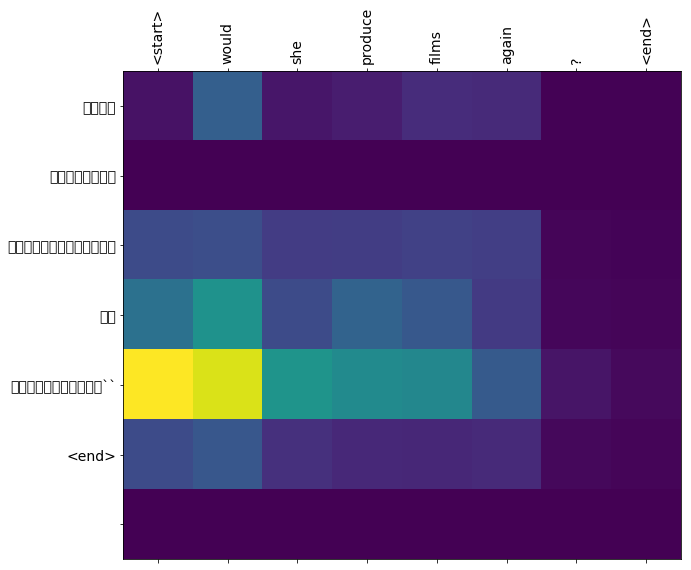

In [60]:
translate(u'Would she produce films again?')

Input: <start> this will keep getting better <end>
Predicted translation: இந்த பகுதி <end> 


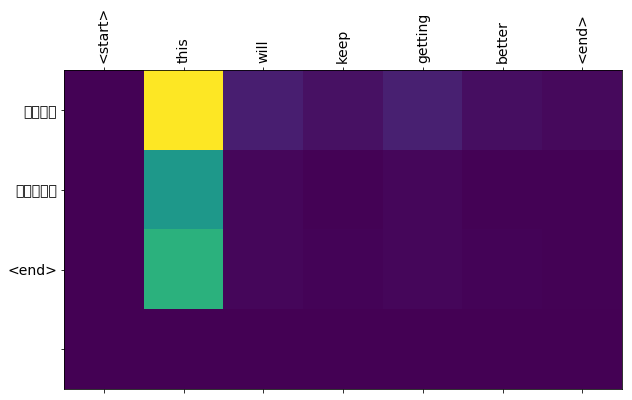

In [61]:
#print(Bleu_score)
translate(u'This will keep getting better')
#translate(u'Sorry for confusing you')
#translate(u'Hey who are you man')
#translate(u'How are you man')

Input: <start> tamilnadu has districts <end>
Predicted translation: தமிழக அரசியல் மாகாணங்களாக நிறுவனம் ( - அதிகாரப்பூர்வ இணையத்தளம் இலங்கை <end> 


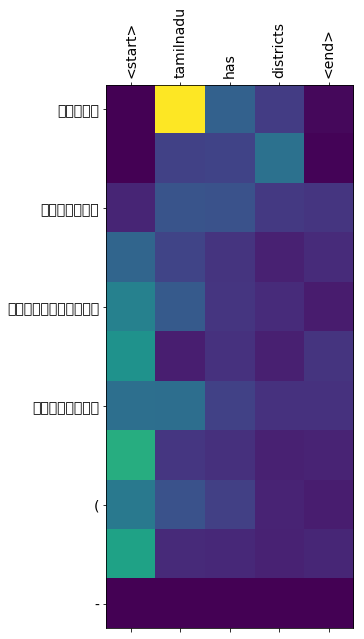

In [62]:
translate('Tamilnadu has 32 Districts')

Input: <start> california university berkely <end>
Predicted translation: ரோசேசியே (மரமுந்திரி குடும்பம்) என்று வேண்டினார் பெர்க்ளி அல்லது கிருமிபோக்கி மூச்சு (1967 நிறம் பூஜாவையும் முன்ஒட்டு ( குடும்பம்; கல் ஆரேப்புமே 


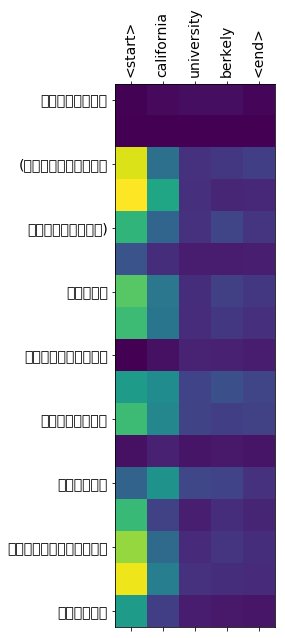

In [63]:
translate('california university, berkely')

Input: <start> watch this film <end>
Predicted translation: இதனால் விளையக்கூடியது அச்சுறுத்தல் மட்டும் குறைந்து இருக்கலாம் என்று எஸ்கேப்பானார் என்று எஸ்கேப்பானார் என்று எஸ்கேப்பானார் என்று எஸ்கேப்பானார் என்று எஸ்கேப்பானார் என்று 


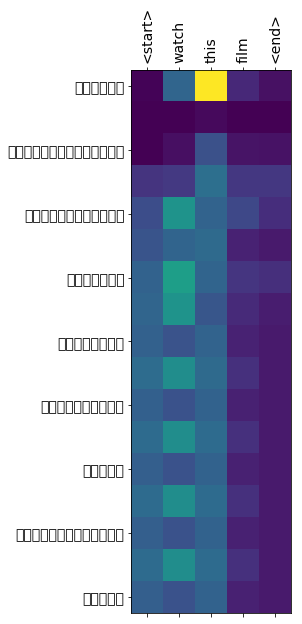

In [64]:
translate(u'watch this film')

Input: <start> hgkhgjgjgj <end>
Predicted translation: நல்வரவு / <end> 


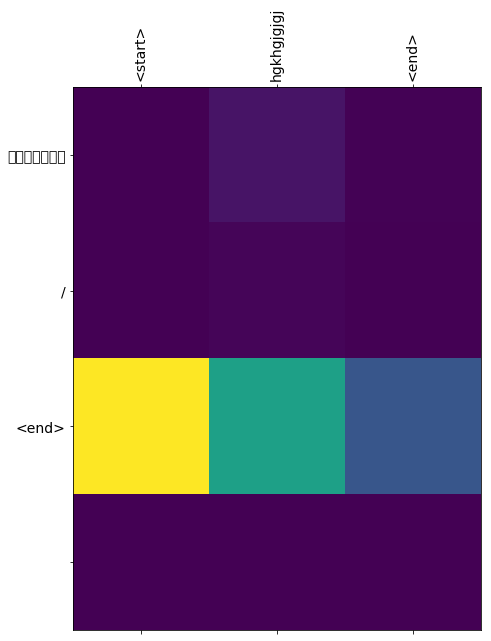

In [79]:
#translate('We can see many trees in south and east part')
#translate('it is good')
translate("hgkhgjgjgj")

#print(Bleu_score)

Input: <start> it is good but not too good <end>
Predicted translation: அது உண்மையில்ல என்று எஸ்கேப்பானார் என்று கேட்டேன் என்று கேட்டேன் என்று கேட்டேன் என்று கேட்டேன் என்று கேட்டேன் என்று கேட்டேன் என்று 


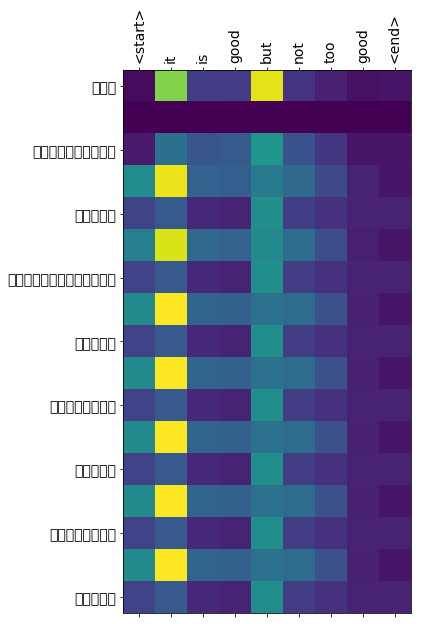

In [66]:
translate('it is good but not too good')

Input: <start> computer <end>
Predicted translation: ருவாண்டா / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் / களஞ்சியம் 


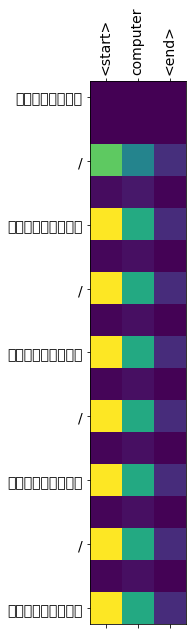

In [67]:
translate('computer')

Input: <start> please contact <end>
Predicted translation: தொடர்பை சேமி - பீவர் - பீவர் - பீவர் - பீவர் - பீவர் - பீவர் - பீவர் - 


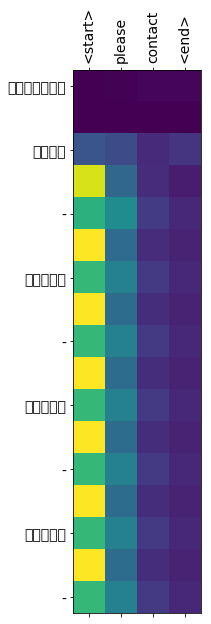

In [68]:
translate('please contact')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
